# Prepping up

In [31]:
!pip install vizdoom
!pip install matplotlib
!pip install torch torchvision
!pip install 'stable-baselines3[extra]'

In [ ]:
from vizdoom import * 
import random
import time 
import numpy as np

In [22]:
# Setup game
game = DoomGame()
game.load_config('./ViZDoom/scenarios/basic.cfg')
game.init()

In [ ]:
# set of actions we can take in the environment
actions = np.identity(3, dtype=np.uint8)

In [ ]:
#game.new_episode()

In [ ]:
#game.is_episode_finished()

True

In [ ]:
#game.make_action(random.choice(actions))

-1.0

In [ ]:
state = game.get_state()
print(state.game_variables)
episodes = 2
for episode in range(episodes): 
    # Creating a new episode or game 
    game.new_episode()
    # Check if the game is done or not 
    while not game.is_episode_finished(): 
        # Geting the game state 
        state = game.get_state()
        # Geting the game image 
        img = state.screen_buffer
        # Geting the game variables - ammo
        info = state.game_variables
        # Taking an action
        reward = game.make_action(random.choice(actions),4)
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

[50.]
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
Result: -365.0
rewa

KeyboardInterrupt: 

In [25]:
game.close()

# Custom Gymnasium

In [26]:
!pip install gymnasium

In [28]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import cv2


In [49]:
# Creating gymnasium Custom Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config('./VizDoom/scenarios/basic.cfg')
        # Rendering the window by selection true or flase 
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Starting the game 
        self.game.init()
        
        # Creating the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4)
         # Get all the other stuff we need to retun
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = {"ammo": ammo}
        else:
            state = np.zeros(self.observation_space.shape, dtype=np.uint8)
            info = {"ammo": 0}

        terminated = self.game.is_episode_finished()
        truncated = False  # VizDoom typically does not truncate

        return state, reward, terminated, truncated, info

    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        if seed is not None:
            self.game.set_seed(seed)

        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        state = self.grayscale(state)

        info = {}
        return state, info
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [51]:
env = VizDoomGym(render=True)

In [34]:
state = env.reset()

In [ ]:
env.reset()

In [56]:
env.close()

In [52]:
# Import Environment checker
from stable_baselines3.common import env_checker
env_checker.check_env(env)

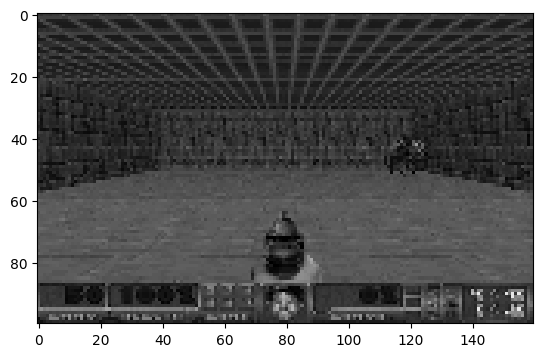

In [ ]:
# Viewing the state in gray 
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [39]:
# Callback def
import os 
from stable_baselines3.common.callbacks import BaseCallback
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [57]:
# Trainig a ppo model
from stable_baselines3 import PPO
env = VizDoomGym()
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048, device="mps")

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [58]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.8     |
|    ep_rew_mean     | -126     |
| time/              |          |
|    fps             | 24       |
|    iterations      | 1        |
|    time_elapsed    | 82       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.6        |
|    ep_rew_mean          | -132        |
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 171         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009629396 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -1.97e-05 

In [64]:
# Testing the agent
from stable_baselines3.common.evaluation import evaluate_policy

model = PPO.load('./train/train_basic/best_model_60000')
# Create rendered environment
env = VizDoomGym(render=True)
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=20)
print('Mean reward:', mean_reward)
#model.predict(obs)
for episode in range(20): 
    obs, info= env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)


Mean reward: 79.05
Total Reward for episode 0 is 134.0
Total Reward for episode 1 is 190.0
Total Reward for episode 2 is 182.0
Total Reward for episode 3 is 158.0
Total Reward for episode 4 is 158.0
Total Reward for episode 5 is 174.0
Total Reward for episode 6 is 190.0
Total Reward for episode 7 is 158.0
Total Reward for episode 8 is 158.0
Total Reward for episode 9 is 190.0
Total Reward for episode 10 is 134.0
Total Reward for episode 11 is 142.0
Total Reward for episode 12 is 174.0
Total Reward for episode 13 is 182.0
Total Reward for episode 14 is 158.0
Total Reward for episode 15 is 150.0
Total Reward for episode 16 is 174.0
Total Reward for episode 17 is 174.0
Total Reward for episode 18 is 158.0
Total Reward for episode 19 is 134.0


In [65]:
env.close()